In [4]:
# %load topxpercent.py
import pandas
import re
import os
import matplotlib.pyplot as plt
import imageio
import shutil

# the top locations that make up targetPercent of the worlds population for the given year
# data taken from the given file ('assumed to be the output of the reformated population data)
# populations are in thousands


def saveGraphCumulative(totals, filename, meta):
    variant, year, percent = meta

    plt.xticks(rotation=90)
    plt.title("%s, %s | %s of total" % (variant, year, str(percent)+"%"))
    plt.plot(totals["Location"], totals["CumPercent"])
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()


def graphCumulative(totals):
    plt.xticks(rotation=90)
    plt.plot(totals["Location"], totals["CumPercent"])
    plt.show()


def findTopXPercent(variant, year, targetPercent):
    # returns top Locations as well as cumulative percentage
    fileName = "data/TotalPopulation_%s.csv" % (variant)
    popDF = pandas.read_csv(fileName)

    # extract the totals per country from the data
    yearData = popDF[["LocationID", "Location", "Group", year]]
    yearTotals = yearData.loc[yearData["Group"] == "Total"]
    # ^ a DF with the location and its total population for the year given

    # extract the world's total population for the year
    # get the total world population for the year as given by the data
    totalWorldPopulation = yearTotals.loc[yearTotals["Location"] == "World"][year].item()
    # print(totalWorldPopulation)

    with open("country-list.txt") as country_list:
        # read in list of countries
        countries_file = country_list.read()

    # make list of countries
    countries = countries_file.split("\n")  # split on newline instead of whitespace (we want two worded countries)
    countries = [c for c in countries if c]  # remove empty lines
    countriesDF = pandas.DataFrame(data={"countries": countries})
    # print(countriesDF.countries)

    # remove all non-country locations by merging
    # make a common dataframe that has only countries and removes non-countries, dropping na values
    common = countriesDF.merge(yearTotals, how='inner', left_on=['countries'], right_on=['Location'])
    yearTotals = common.dropna()
    yearTotals = yearTotals.drop(columns=["countries"])  # drop countries since same as location
    # print(yearTotals)

    # find the percent of the world's total by location and add a column with that
    yearTotals["Percent"] = yearTotals[year]/totalWorldPopulation  # % of the world's population

    # sort by percent of world population
    yearTotals.sort_values(by=["Percent"], ascending=False, inplace=True)
    # print(yearTotals)

    # find the cumulative sum of percent
    yearTotals["CumPercent"] = yearTotals["Percent"].cumsum()
    # print(yearTotals)

    # find the locations that collectively make up targetPercent of the world's population
    topLocations = yearTotals[yearTotals["CumPercent"] < targetPercent]
    # print(topLocations)

    # the locations with populations than targetPercent (not needed, but done for fun)
    # greaterLocations = yearTotals.loc[yearTotals["Percent"] > targetPercent]
    # print(greaterLocations)

    return yearTotals, topLocations


def findTop():

    variant = "Medium"  # can be:
    #  "ConstantFertility" "ConstantMortality" "High" "InstantReplacement" "Low" "Medium" "Momentum" "NoChange" "ZeroMigration"

    year = "2020"
    targetPercent = 0.61  # 0 to 1
    # returns top Locations as well as cumulative percentage
    cumulativeTotals, topLocations = findTopXPercent(variant, year, targetPercent)

    # drops group not needed
    cumulativeTotals.drop(['Group'], axis=1, inplace=True)

    # exporting dataframe to intermediate data folder
    newfile = "intermediate-data/Medium-TotalPop-CountID%s.csv" % (year)
    # export_csv = cumulativeTotals.to_csv(newfile, index = None, header=True)  #Don't forget to add '.csv' at the end of the path

    # graph the cumulative sum (does not depend on targetPercent)
    # graphCumulative(cumulativeTotals)
    graphCumulative(topLocations)  # plot only the topLocations


def createGif():

    variants = ["ConstantFertility", "ConstantMortality", "High", "InstantReplacement", "Low", "Medium", "Momentum", "NoChange", "ZeroMigration"]
    variant = "Medium"  # can be:
    #  "ConstantFertility" "ConstantMortality" "High" "InstantReplacement" "Low" "Medium" "Momentum" "NoChange" "ZeroMigration"

    years = [str(y) for y in range(1950, 2101)]
    # years = [str(y) for y in range(2000, 2021)]
    targetPercent = 0.61  # 0 to 1
    # returns top Locations as well as cumulative percentage

    # crate temp folder
    if not os.path.isdir("tempimages"):
        os.mkdir("tempimages")

    if not os.path.isdir("gifs"):
        os.mkdir("gifs")

    imagenames = []
    gifname = "gifs/top%dpercent.gif" % (int(targetPercent*100))  # makes 0.xx to xx%
    for year in years:
        print("Variant: %s, year: %s" % (variant, year), end="\r")  # \r makes it stay on the same line
        cumulativeTotals, topLocations = findTopXPercent(variant, year, targetPercent)

        # save image
        imgname = "tempimages/image_%s_%s.png" % (variant, year)
        imagenames.append(imgname)
        metadata = (variant, year, targetPercent)
        saveGraphCumulative(topLocations, imgname, metadata)

    print("\nDone creating images")
    # create the gif
    totalFiles = len(imagenames)
    imgnum = 0
    figures = []
    for img in imagenames:
        imgnum += 1
        print("processing %s  [%d/%d]" % (img, imgnum, totalFiles), end="\r")
        figures.append(imageio.imread(img))

    imageio.mimsave(gifname, figures, duration=0.25)
    print("gif made at % s" % (gifname))

    # remove images and temp folder
    if os.path.isdir("tempimages"):  # should always be true here
        shutil.rmtree("tempimages")
    print("Images, temp folder removed")


# findTop()
#createGif()


In [5]:
# %load generalGifs.py
import os
import imageio
import shutil


# Flow:
# call initFolders()
#     tempfolder and all contents will be automatically removed
# create and save figure images in folder tempimages/
#     save the path name into a list
#        imglist = ["tempimages/img1.png", "tempimages/img2.png"...]
# pass that list and the desired name of the gif into createGif(imglist,gifname, speed)
#     note: gif will automatically be put into gifs/ folder don't include "gifs/" in the path for gifname
#     example call: createGif(imglist,"foo.gif")
#     speed is the time in between frames in seconds (default = 0.25)

def initFolders():
    # crate temp folder
    if not os.path.isdir("tempimages"):
        os.mkdir("tempimages")
    else:
        for filename in os.listdir("tempimages"):
            os.remove("tempimages/%s" % (filename))

    if not os.path.isdir("gifs"):
        os.mkdir("gifs")


def createGif(imageList, gifname, speed=0.25):
    gifname = "gifs/%s" % (gifname)
    # create the gif
    # https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python

    totalFiles = len(imageList)
    imgnum = 0
    figures = []
    for img in imageList:
        imgnum += 1
        print("[%d/%d] | processing %s \t\t\t" % (imgnum, totalFiles, img), end="\r")
        figures.append(imageio.imread(img))

    imageio.mimsave(gifname, figures, duration=speed)
    print("\ngif made at % s" % (gifname))

    # remove images and temp folder
    if os.path.isdir("tempimages"):  # should always be true here
        shutil.rmtree("tempimages")
    print("Images, temp folder removed")


In [6]:
import geopandas as gpd
shapefile = 'intermediate-data/ne_10m_admin_0_countries.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
#gdf

In [7]:
print(gdf[gdf['country'] == 'Antarctica'])
#Drop row corresponding to 'Antarctica'
gdf = gdf.drop(gdf.index[159])

        country country_code  \
172  Antarctica          ATA   

                                              geometry  
172  (POLYGON ((-51.73064133499992 -82.062556536999...  


In [8]:
import pandas as pd
countrycodefile = 'intermediate-data/all-country-list.csv'
#Read country code list csv file using pandas
cf = pd.read_csv(countrycodefile, names = ['countryname', 'al2', 'al3code','countrycode','iso','region','subr','intr','rcode','subrcode','intrcode'], skiprows = 1)
cf.drop(['iso','region','subr','intr','rcode','subrcode','intrcode'],axis=1,inplace=True)
#cf

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


variants = ["ConstantFertility", "ConstantMortality", "High", "InstantReplacement", "Low", "Medium", "Momentum", "NoChange", "ZeroMigration"]
years = [str(y) for y in range(1950, 2101)]
variant = "Medium"
#target percent does not change the graph
targetPercent = 0.61 
#going through all of the variants
#for variant in variants:
#creating test files
initFolders()
#list of image paths
imagenames=[]
for year in years:
    #finds percentage of country's population/ total world population
    cumulativeTotals, topLocations = findTopXPercent(variant, year, targetPercent)
    cumulativeTotals.drop(['Group'], axis=1, inplace=True)
    #print(cumulativeTotals)
    #merging data frames with numerical country code
    halfmerge = cf.merge(cumulativeTotals, left_on = 'countrycode', right_on = 'LocationID')
    #merging data frames with the 3 character country code
    merged = gdf.merge(halfmerge, left_on = 'country_code', right_on = 'al3code')
    print("Variant: %s, year: %s" % (variant, year), end="\r")
    colors =10
    #cmap = 'RdPu'
    #defining color map and only taking subset of the sequential color
    viridisBig = cm.get_cmap('GnBu', 512)
    newcmp = ListedColormap(viridisBig(np.linspace(0.45, 0.95, 256)))
    figsize = (16, 10)
    bi = [0.02, 0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2]
    ax = merged.plot(column='Percent', cmap=newcmp, figsize=figsize,scheme='User_Defined',classification_kwds={'bins':bi},k=colors,legend=True)
    ax.set_axis_off()
    leg = ax.get_legend()
    #leg.get_texts()[0].set_text('New label 1')
    #ax.set_xlim([-1.5e7, 1.7e7])
    ax.get_legend().set_bbox_to_anchor((.12, .4))
    plt.title('%s density of total population % s' % (variant, year))
    #saving images
    imgname = "tempimages/densityimage_%s_%s.png" % (variant, year)
    imagenames.append(imgname)
    plt.savefig(imgname, bbox_inches='tight')
    #clear plot
    plt.clf()
#for each variant call create gif
gifname = "density_%s.gif" %(variant)
createGif(imagenames,gifname,0.1)
        

[151/151] | processing tempimages/densityimage_Medium_2100.png 			
gif made at gifs/density_Medium.gif
Images, temp folder removed


<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

In [6]:
#half merge 
#merging country-list and medium total pop data set
halfmerge = cf.merge(df, left_on = 'countrycode', right_on = 'locationid')
#halfmerge

In [7]:
merged = gdf.merge(halfmerge, left_on = 'country_code', right_on = 'al3code')
merged.loc[merged['country_code'] == 'NAM']

,country,country_code,geometry,countryname,al2,al3code,countrycode,locationid,location,year,per_cent,cum_percent
34,Namibia,NAM,POLYGON ((16.48707116000008 -28.57293059699992...,Namibia,NaN,NAM,516,516,Namibia,2696.537,0.000346,0.994081


Text(0.5, 1.0, 'MEDIUM TOTAL POPULATION -2099')

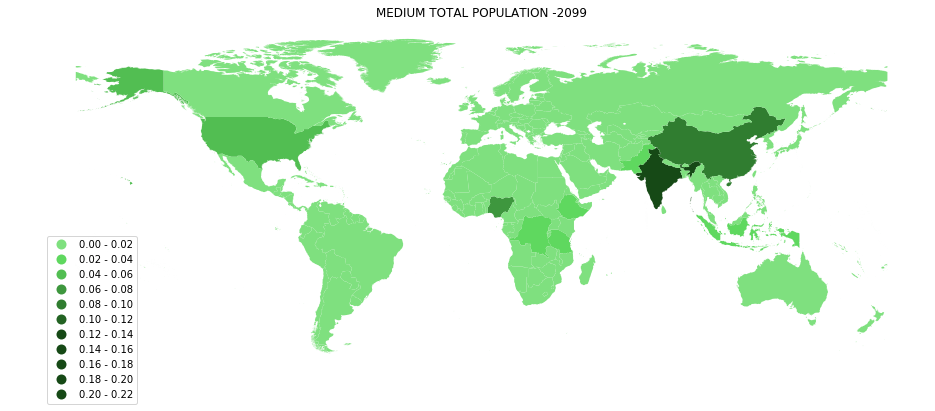

In [120]:
#GRAPH OF MEDIUM-TOTAL POPULATION 2099
#takes percent of country's population compared to the world and maps that
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


import matplotlib as mpl
colors =10
cmap = 'RdPu'
bi = [0.02, 0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22]
color_dict1 = {'dg': '#7fe07f',
               'dg2': '#5fd85f',
               'dg3': '#58cb58',
               'dg4': '#52be52',
               'dg5': '#44a444',
               'dg6': '#3e973e',
               'dg7': '#378a37',
               'dg8': '#307d30',
               'dg9': '#2a702a',
               'dg10': '#236323',
               'dg11': '#164916'}

newcmp = LinearSegmentedColormap.from_list('newcmp', [
    color_dict1['dg'],
    color_dict1['dg2'],
    color_dict1['dg3'],
    color_dict1['dg4'],
    color_dict1['dg5'],
    color_dict1['dg6'],
    color_dict1['dg7'],
    color_dict1['dg8'],
    color_dict1['dg9'],
    color_dict1['dg10'],
    color_dict1['dg11']],N=11)

# viridisBig = cm.get_cmap('GnBu', 11)
# newcmp = ListedColormap(viridisBig(np.linspace(0.25,0.95, 1024)))
figsize = (16, 10)
#levels = np.linspace(0,0.2, 10)
bounds = [0, 0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9]
#fig, (axs1) = plt.subplots(1, 1)

ax = merged.plot(column='Percent', cmap=newcmp, figsize=figsize,scheme='User_Defined',classification_kwds={'bins':bi},legend=True)
# cb2 = mpl.colorbar.ColorbarBase(axs1, cmap=newcmp,
#                                 extend='both',
#                                 ticks=bounds,
#                                 spacing='proportional')

ax.set_axis_off()
leg = ax.get_legend()
#leg.get_texts()[0].set_text('New label 1')
#ax.set_xlim([-1.5e7, 1.7e7])
ax.get_legend().set_bbox_to_anchor((.12, .4))
#ax.get_figure()
# scheme='equal_interval',k=colors,legend=True
# plt.imshow(ax, cmap='RdBu')
# plt.colorbar(extend='both')
# plt.clim(0, 1)
plt.title('MEDIUM TOTAL POPULATION -2099')